In [49]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.8

import numpy as np
import casadi as ca
import time
from helper_fns import yaml_load

def timed_exec(fn, *args):
    start = time.time()
    res = fn(*args)
    elapsed = time.time() - start
    return elapsed, *res


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from helper_fns import spawn_models
from mpc import MPC

mpc_params = yaml_load('config/mpc_params.yaml')
ipopt_options = yaml_load('config/ipopt_options.yaml')

_, robots, contacts = spawn_models(robot_path = "config/franka.yaml",
                                   attr_path  = "config/attrs.yaml", 
                                   contact_path = "config/contact_test.yaml",
                                   sym_vars = [])

q0 = np.ones(7)
dq0 = 0.0*np.ones(7)

params = {'q': q0,
          'dq': dq0,
          'belief_free':1.0,
          'belief_point':0.0,
          'imp_stiff':400*ca.DM.ones(3),}

In [51]:
# MPC only, i.e. without iCEM warmstart
mpc = MPC(robots, 
          mpc_params=mpc_params, 
          ipopt_options=ipopt_options,
          icem=False)

params['belief_free'] = 1.0
params['belief_point'] = 0.0

t_mpc_free_cold, cost, res = timed_exec(mpc.solve, params)
t_mpc_free_warm, cost, res = timed_exec(mpc.solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0

t_mpc_point, cost2, res2 = timed_exec(mpc.solve, params)

print(f"Free space cold {t_mpc_free_cold}, Free space warm {t_mpc_free_warm}, Point: {t_mpc_point}, Cost: {cost2}")
res['imp_stiff'] = params['imp_stiff']
#traj = robots['free'].get_ext_state(res)
#print(cost)
#print(traj['imp_rest'])

Free space cold 1.3430655002593994, Free space warm 0.021218538284301758, Point: 0.04693889617919922, Cost: 3.4867


In [52]:
# iCEM-only result
mpc_params['num_iter'] = 10
mpc.icem_init()

params['belief_free'] = 1.0
params['belief_point'] = 0.0
time_cem_free, cost, res = timed_exec(mpc.icem_solve, params)

params['belief_free'] = 0.0
params['belief_point'] = 1.0
time_cem_point, cost, res = timed_exec(mpc.icem_solve, params)
print(f"Free space {time_cem_free}, Point: {time_cem_point}, Cost: {cost}")


Free space 0.21064424514770508, Point: 0.18711042404174805, Cost: 4.8235


In [53]:
iters = [0, 1, 2, 3, 4]
N = 20
mpc = MPC(robots, mpc_params=mpc_params, ipopt_options=ipopt_options, icem=False)
iter_times_mean = []
iter_times_std = []
iter_cost_mean = []
iter_cost_std = []
for n_iter in iters:
    times = []
    costs = []
    for _ in range(N):
        mpc.icem_init()
        params['belief_free'] = 1.0
        params['belief_point'] = 0.0 
        mpc.solve(params)

        params['belief_free'] = 0.0
        params['belief_point'] = 1.0
        params['q'] = 0.005*np.random.randn(7) # perturb initial state
        tic = time.perf_counter()
        mpc.icem_warmstart(params, num_iter=n_iter)
        cost, _ = mpc.solve(params)
        times.append(time.perf_counter()-tic)
        costs.append(np.squeeze(cost.full()))
    iter_times_mean.append(np.mean(times))
    iter_times_std.append(np.std(times))
    iter_cost_mean.append(np.mean(costs))
    iter_cost_std.append(np.std(costs))

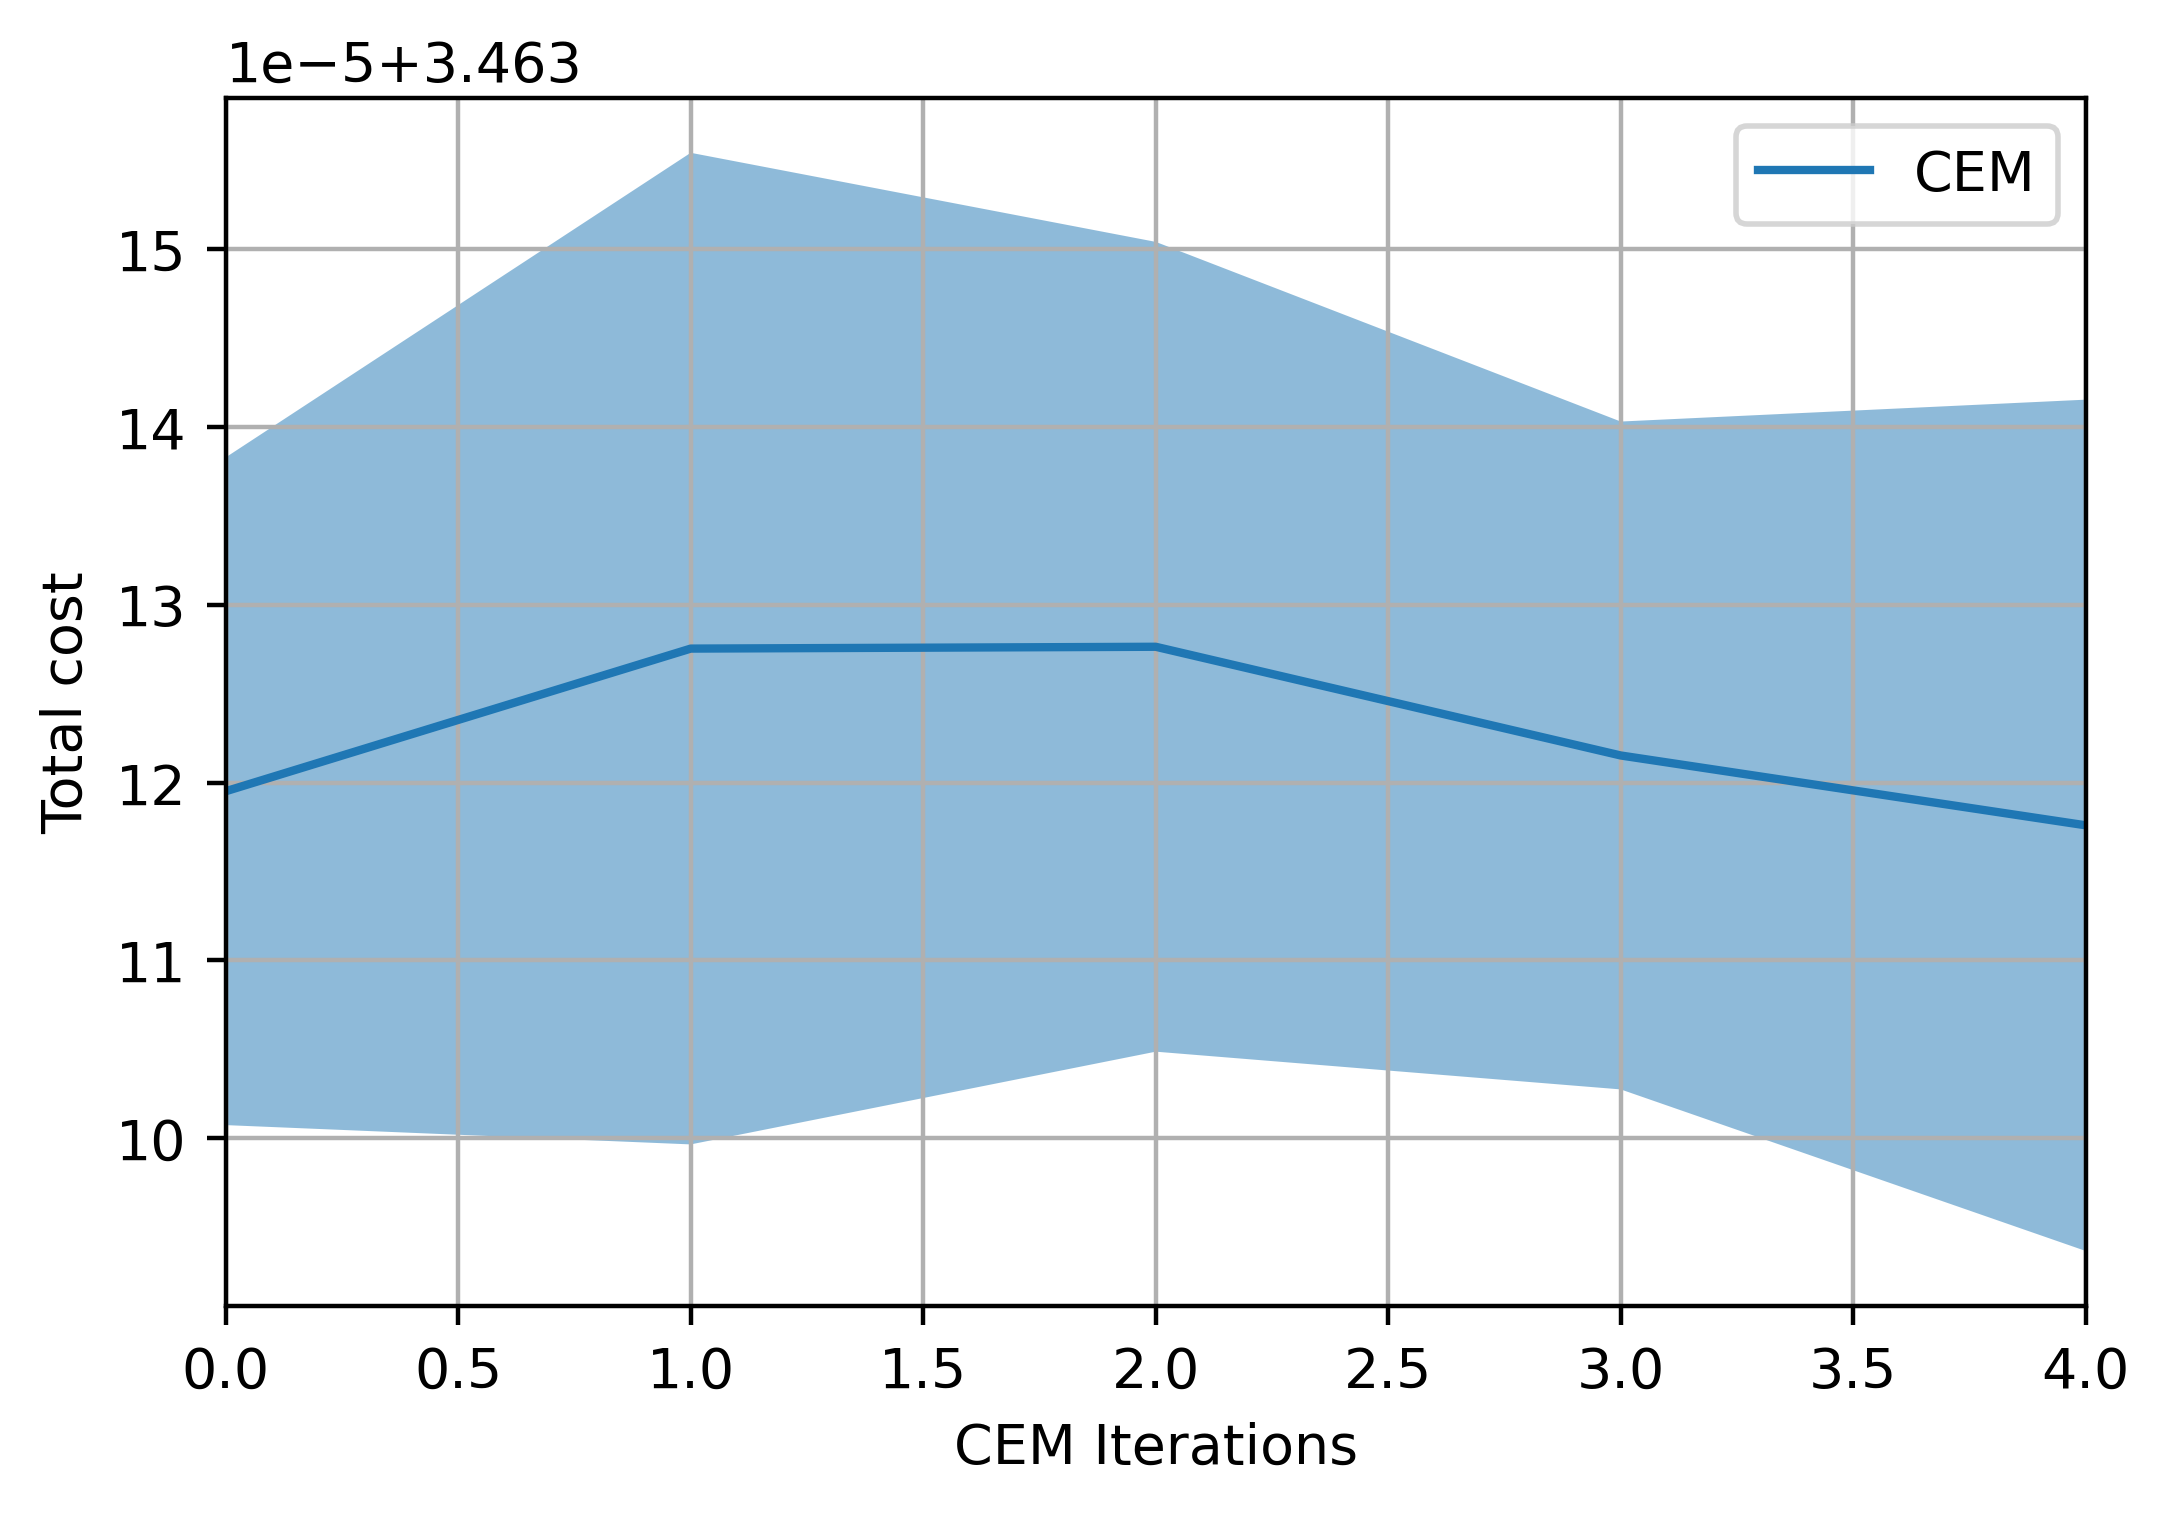

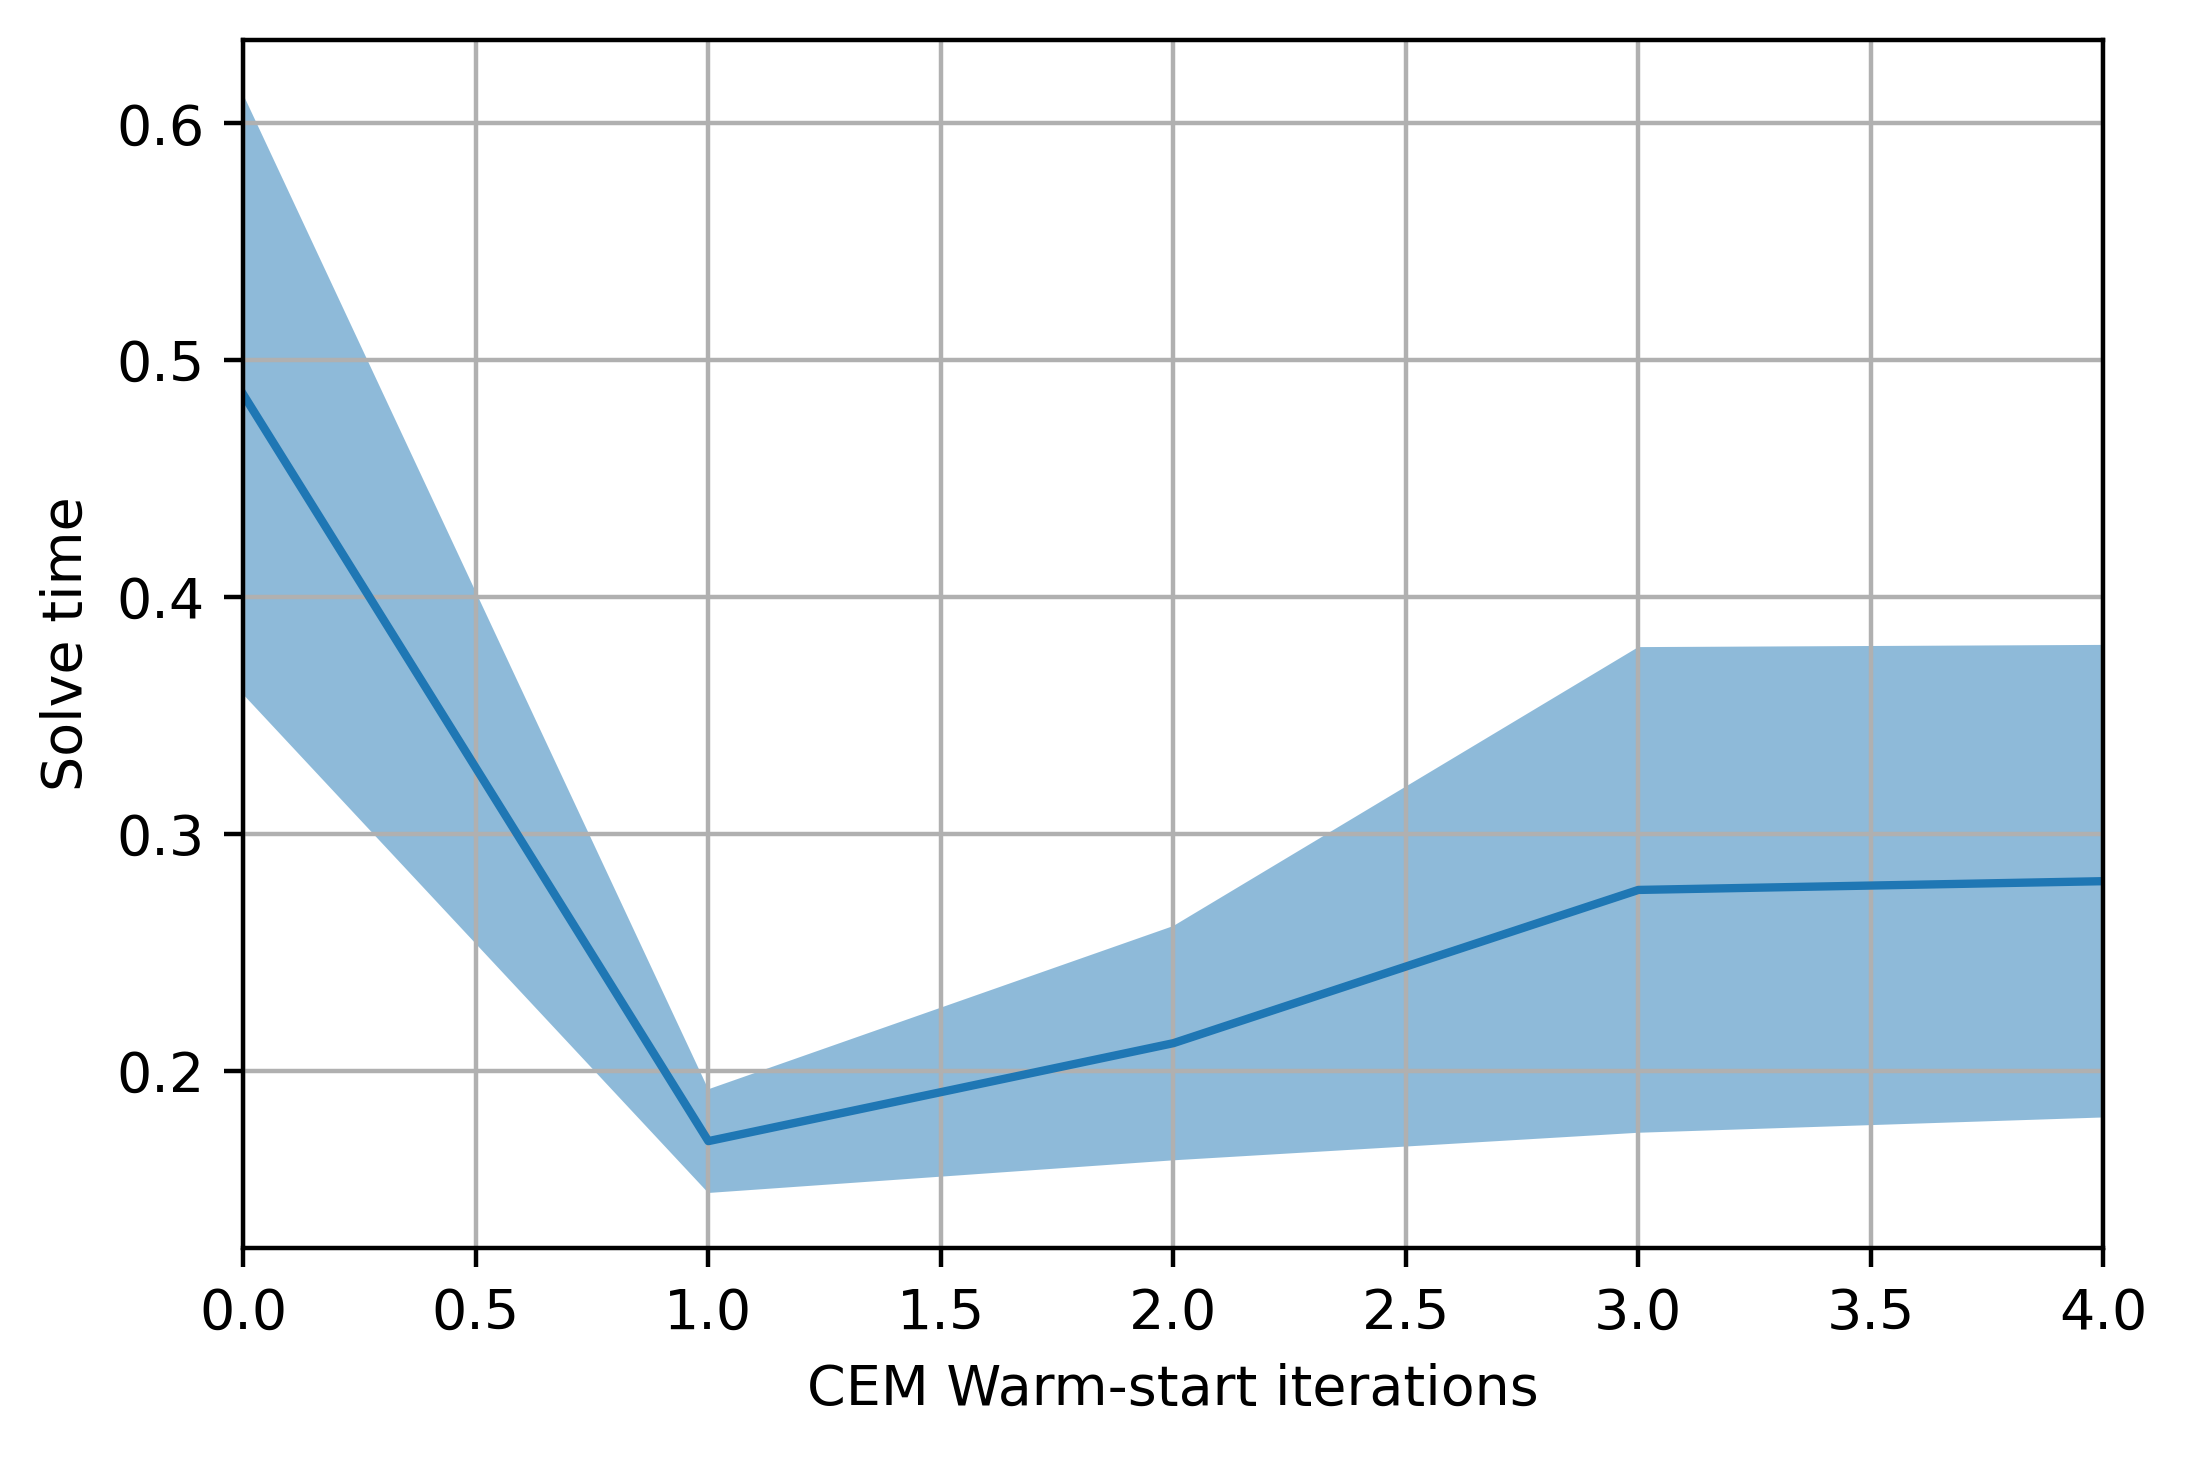

In [54]:
plt.plot(iters, iter_cost_mean, label='CEM')
mu = np.array(iter_cost_mean)
sig = np.array(iter_cost_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)

plt.legend()
plt.xlim(0,iters[-1])
plt.xlabel('CEM Iterations')
plt.ylabel('Total cost')


plt.figure()
plt.plot(iters, iter_times_mean)
mu = np.array(iter_times_mean)
sig = np.array(iter_times_std)
plt.fill_between(iters, mu-sig, mu+sig, alpha=0.5)
plt.xlim(0,iters[-1])
plt.xlabel('CEM Warm-start iterations')
plt.ylabel('Solve time')
plt.savefig('cem_warmstart_num_iter.pdf')